### Generative Adversarial Network (GAN)
#### Uses: Generator & Discriminator
#### Goal: Train a GAN on the MNIST dataset (handwritten digits) to generate realistic images of digits.

Epoch 0/10000, [D loss: 8.1193], [G loss: 0.0117]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


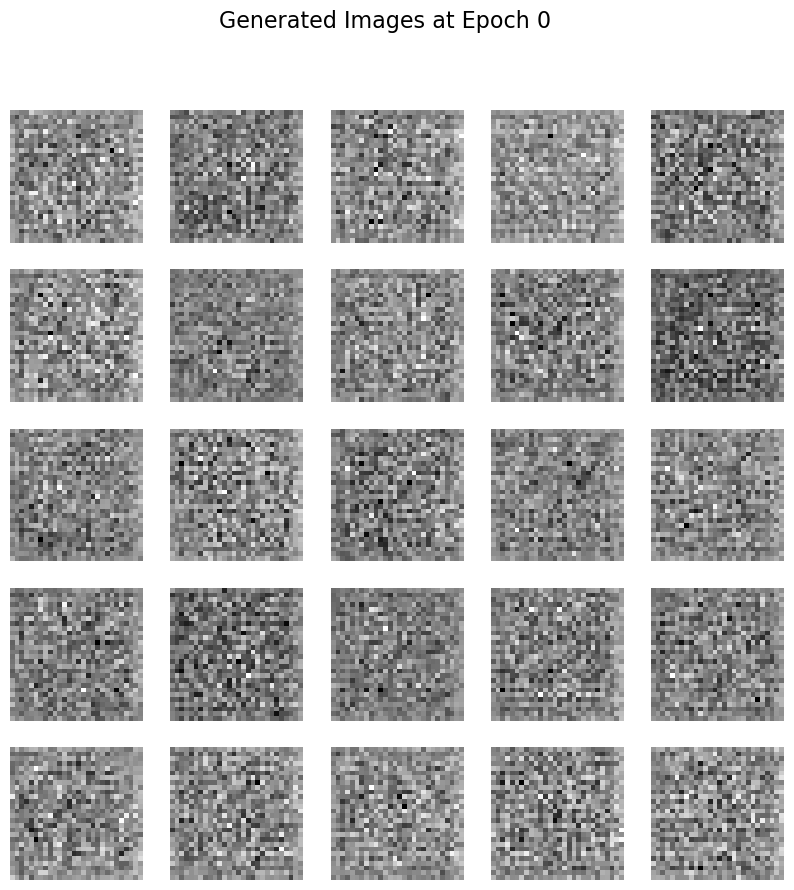

Epoch 1000/10000, [D loss: -0.1399], [G loss: -13.2547]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


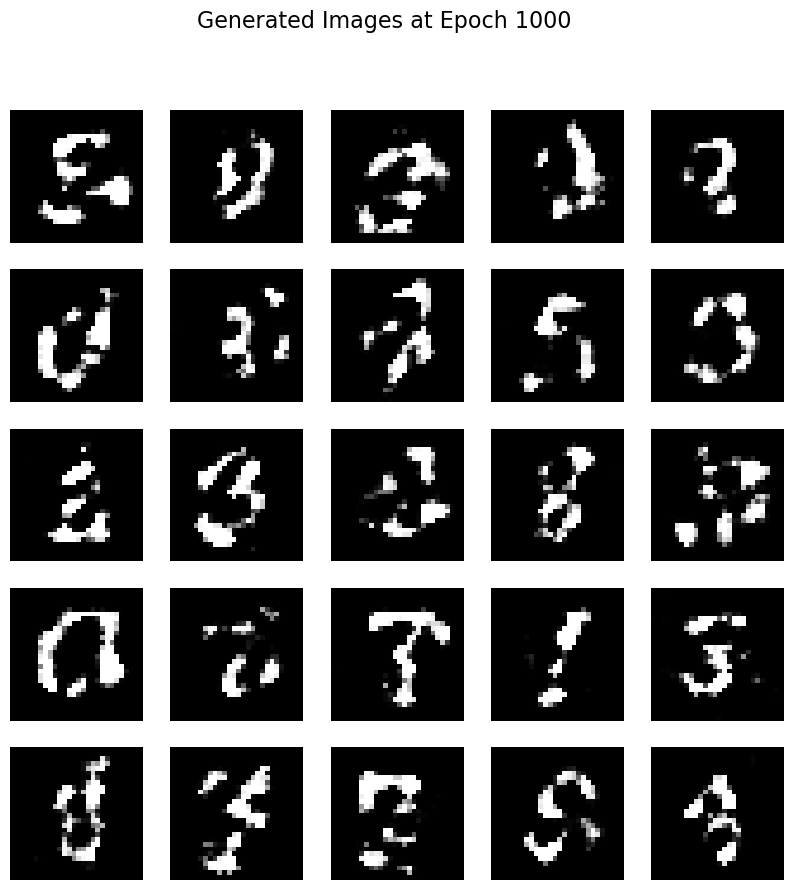

Epoch 2000/10000, [D loss: -0.6275], [G loss: -16.3928]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


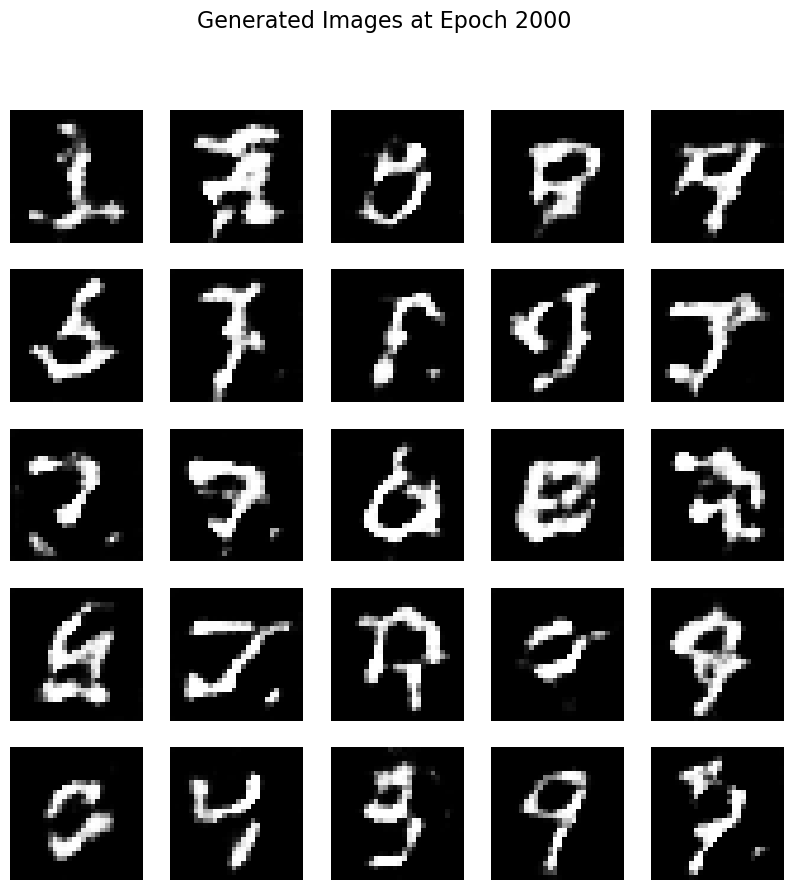

Epoch 3000/10000, [D loss: -0.2223], [G loss: -18.3680]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


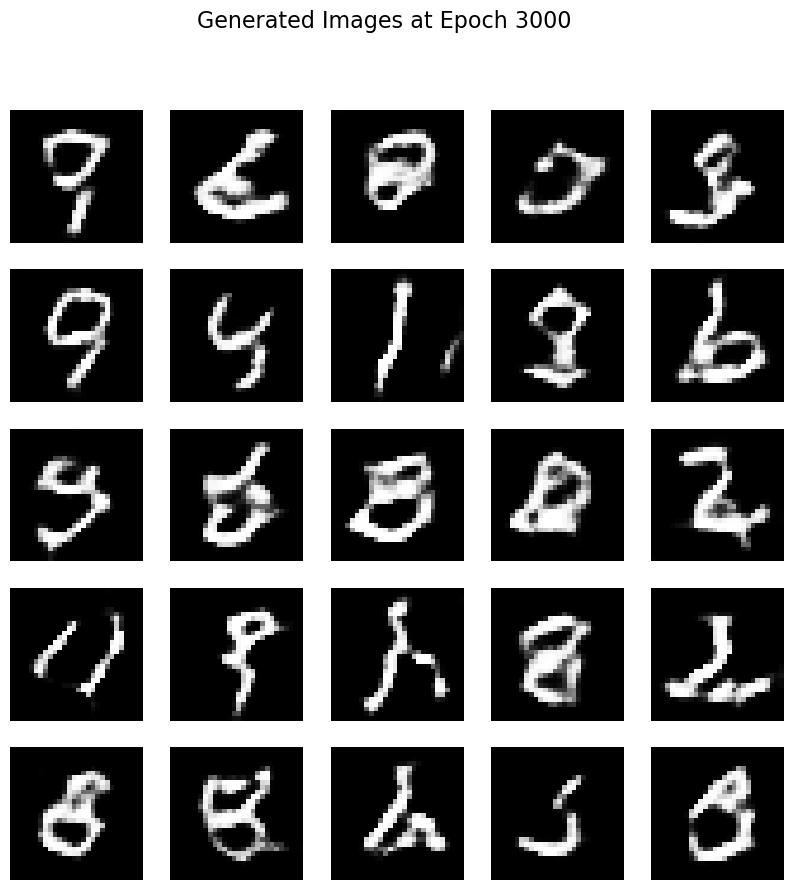

Epoch 4000/10000, [D loss: -0.3305], [G loss: -17.2516]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


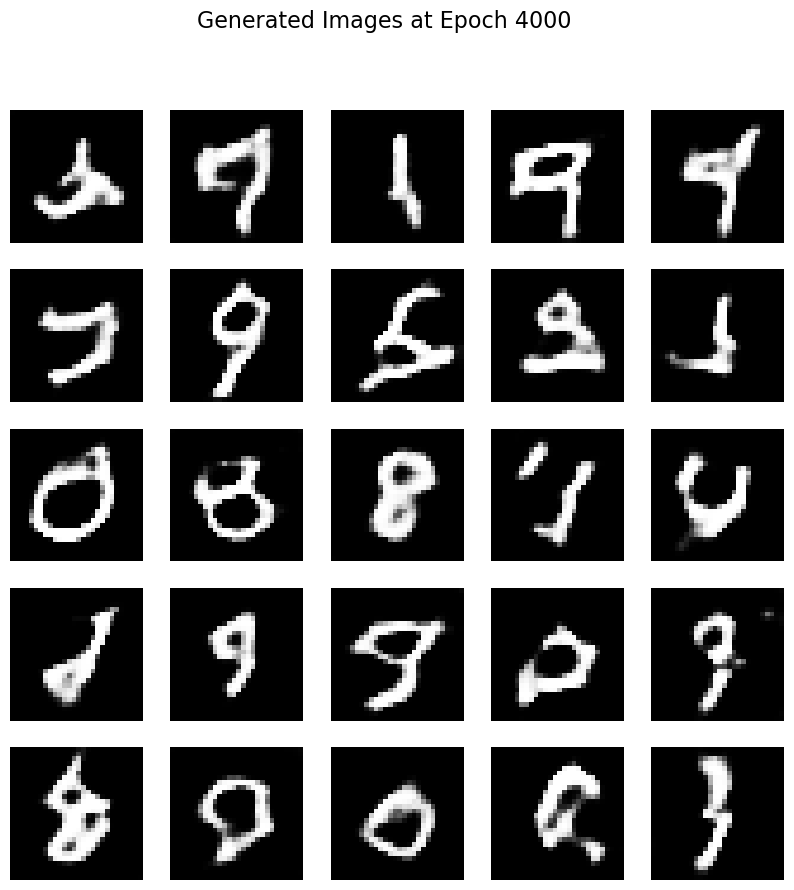

Epoch 5000/10000, [D loss: -0.2114], [G loss: -17.2587]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


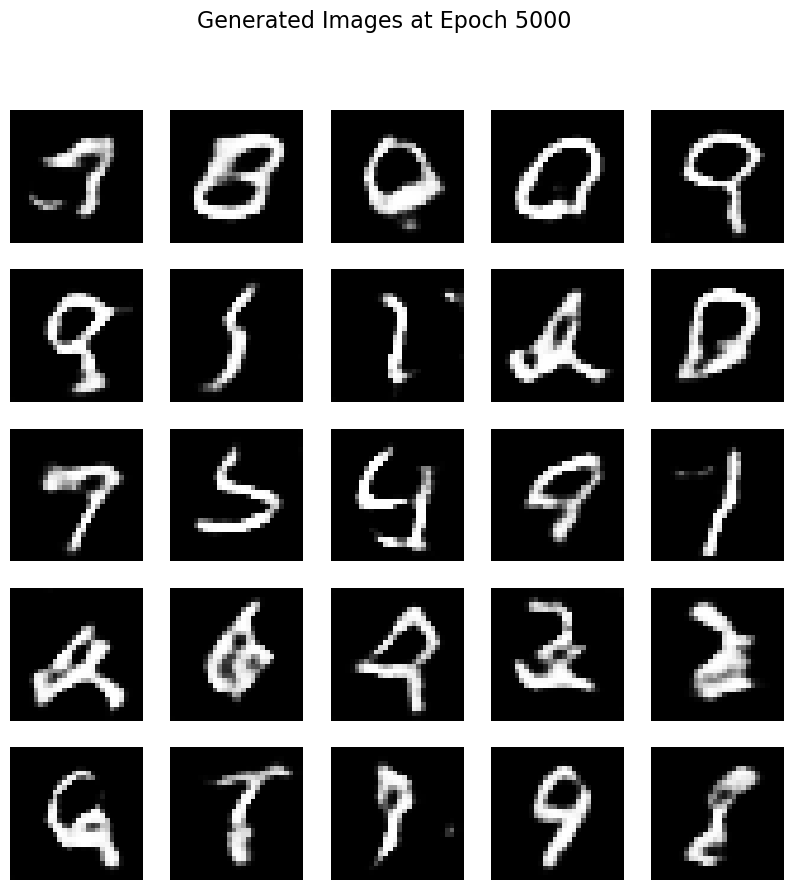

Epoch 6000/10000, [D loss: -0.5310], [G loss: -18.1901]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


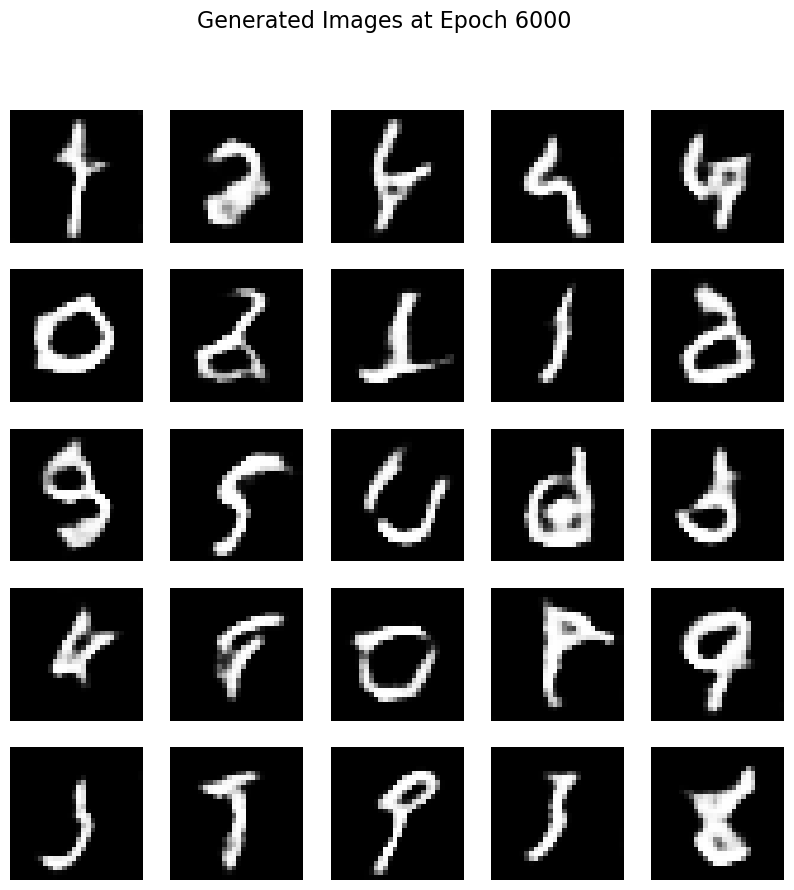

Epoch 7000/10000, [D loss: -0.4164], [G loss: -18.6462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


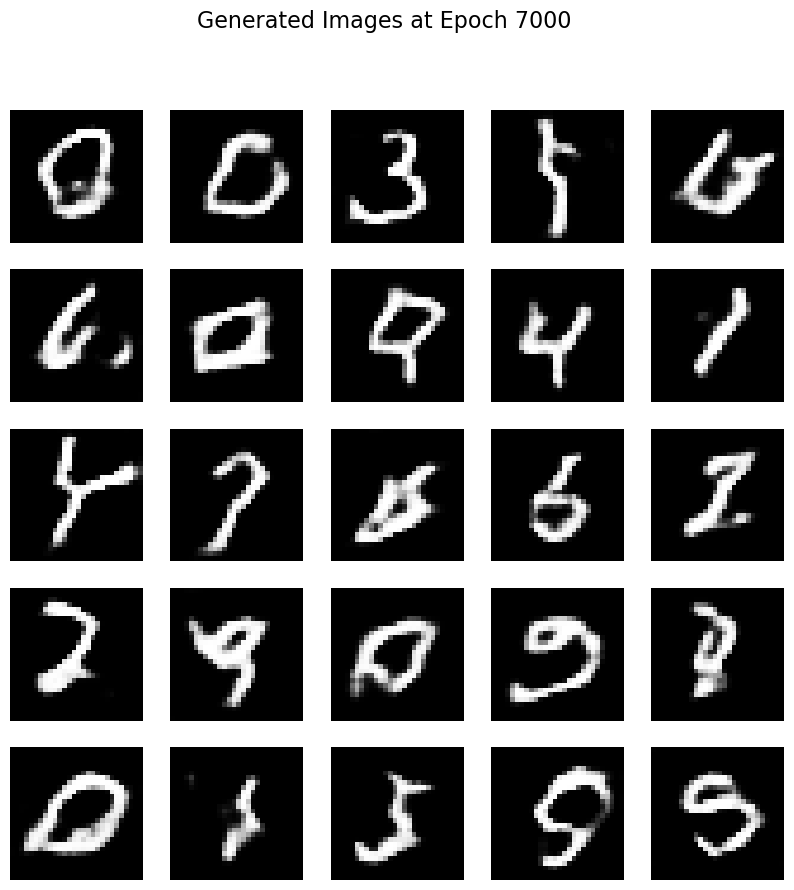

Epoch 8000/10000, [D loss: -0.3262], [G loss: -18.3047]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


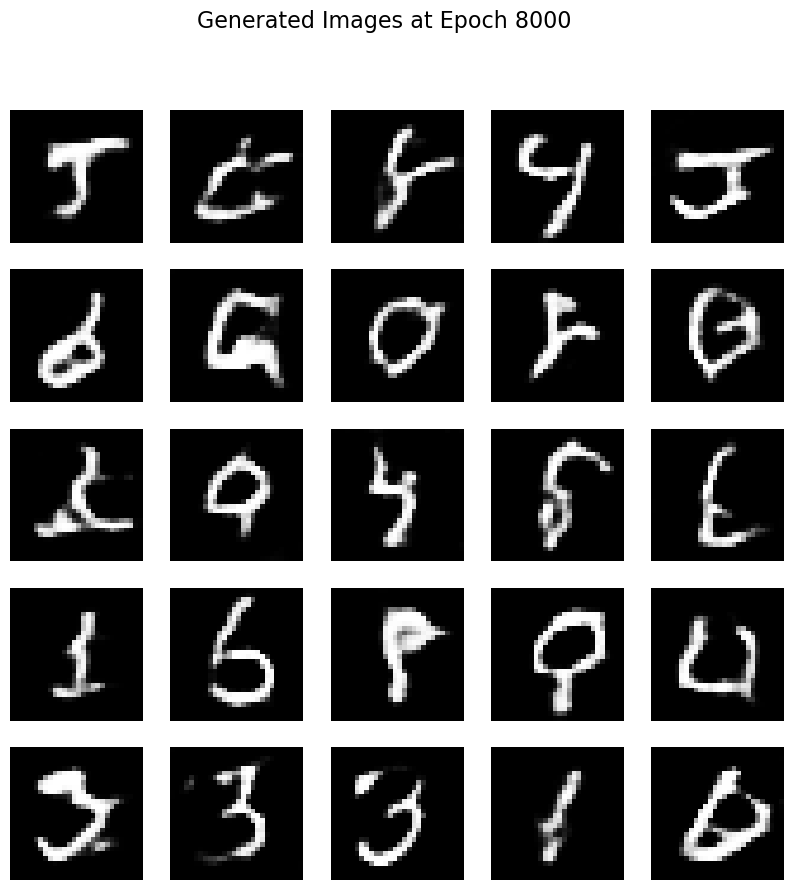

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST dataset
(x_train, _), (_, _) = mnist.load_data()
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)  # Reshape to (28, 28, 1)

# Wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return tf.keras.backend.mean(y_true * y_pred)

def gradient_penalty(discriminator, real_images, fake_images, batch_size):
    """Calculates the gradient penalty for WGAN-GP"""
    alpha = tf.random.uniform((batch_size, 1, 1, 1), 0, 1, dtype=tf.float32)
    real_images = tf.cast(real_images, tf.float32)  # Ensure correct data type
    fake_images = tf.cast(fake_images, tf.float32)  # Ensure correct data type
    interpolated = alpha * real_images + (1 - alpha) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated)
    grads = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return penalty


# Generator
def build_generator():
    model = models.Sequential([
        layers.Dense(7 * 7 * 128, input_dim=100),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(0.2),
        layers.Conv2D(1, kernel_size=7, activation="tanh", padding="same")
    ])
    return model

# Discriminator
def build_discriminator():
    model = models.Sequential([
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(28, 28, 1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Build generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Optimizers
g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)
d_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)

# Training parameters
epochs = 10000
batch_size = 64
sample_interval = 1000
lambda_gp = 10  # Gradient penalty coefficient

# Training loop
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]

    # Train discriminator
    noise = tf.random.normal((batch_size, 100))
    fake_images = generator(noise, training=True)
    with tf.GradientTape() as d_tape:
        real_pred = discriminator(real_images, training=True)
        fake_pred = discriminator(fake_images, training=True)
        gp = gradient_penalty(discriminator, real_images, fake_images, batch_size)
        d_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + lambda_gp * gp
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal((batch_size, 100))
    with tf.GradientTape() as g_tape:
        fake_images = generator(noise, training=True)
        fake_pred = discriminator(fake_images, training=True)
        g_loss = -tf.reduce_mean(fake_pred)
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss

# Save generated images
def save_generated_images(epoch, n=5):
    noise = np.random.normal(0, 1, (n * n, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(n, n, figsize=(10, 10))
    for i in range(n):
        for j in range(n):
            axs[i, j].imshow(gen_imgs[i * n + j, :, :, 0], cmap="gray")
            axs[i, j].axis("off")
    plt.suptitle(f"Generated Images at Epoch {epoch}", fontsize=16)
    plt.show()

# Train GAN
def train_gan(x_train):
    for epoch in range(epochs):
        # Get random batch of real images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]

        # Train the GAN
        d_loss, g_loss = train_step(real_images)

        # Print progress
        if epoch % sample_interval == 0:
            print(f"Epoch {epoch}/{epochs}, [D loss: {d_loss:.4f}], [G loss: {g_loss:.4f}]")
            save_generated_images(epoch)

# Start training
train_gan(x_train)


